In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [35]:
GOOD_DIR = "/archive/casting_data/casting_data/train/good_front/"
DEF_DIR = "/archive/casting_data/casting_data/train/def_front/"
good = os.listdir(GOOD_DIR)
defective = os.listdir(DEF_DIR)

In [36]:
good_paths = []
for i in tqdm(range(0, len(good))):
    good_path = GOOD_DIR + good[i]
    good_paths.append(good_path)
    
defective_paths = []
for i in tqdm(range(0, len(defective))):
    defective_path = DEF_DIR + defective[i]
    defective_paths.append(defective_path)

100%|██████████████████████████████████| 3758/3758 [00:00<00:00, 1699611.22it/s]


In [37]:
good_labels = np.ones(len(good_paths)) # 1 = NON DEFECTIVE
defective_labels = np.zeros(len(defective_paths)) # 0 = DEFECTIVE

In [38]:
train_paths = np.concatenate([
    np.array(good_paths),
    np.array(defective_paths)
])
train_labels = np.concatenate([
    good_labels,
    defective_labels
])

In [39]:
df = pd.DataFrame({"PATHS":train_paths, "LABELS":train_labels})
df = df.sample(frac = 1, )
df

,PATHS,LABELS
2375,/Users/Pooji/Downloads/archive/casting_data/ca...,1.0
1457,/Users/Pooji/Downloads/archive/casting_data/ca...,1.0
415,/Users/Pooji/Downloads/archive/casting_data/ca...,1.0
4267,/Users/Pooji/Downloads/archive/casting_data/ca...,0.0
1125,/Users/Pooji/Downloads/archive/casting_data/ca...,1.0
...,...,...
2688,/Users/Pooji/Downloads/archive/casting_data/ca...,1.0
707,/Users/Pooji/Downloads/archive/casting_data/ca...,1.0
5058,/Users/Pooji/Downloads/archive/casting_data/ca...,0.0
2003,/Users/Pooji/Downloads/archive/casting_data/ca...,1.0


In [40]:
paths = np.array(df.PATHS)
labels = np.array(df.LABELS)

In [41]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(paths, labels, test_size = 0.2)

In [42]:
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, size=(256, 256))
    image = tf.cast(image, dtype= tf.float32)/255
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
train_dataset = train_dataset.map(load_image)
train_dataset = train_dataset.shuffle(buffer_size=500)
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((xval, yval))
val_dataset = val_dataset.map(load_image)
val_dataset = val_dataset.shuffle(buffer_size=500)
val_dataset = val_dataset.batch(32)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

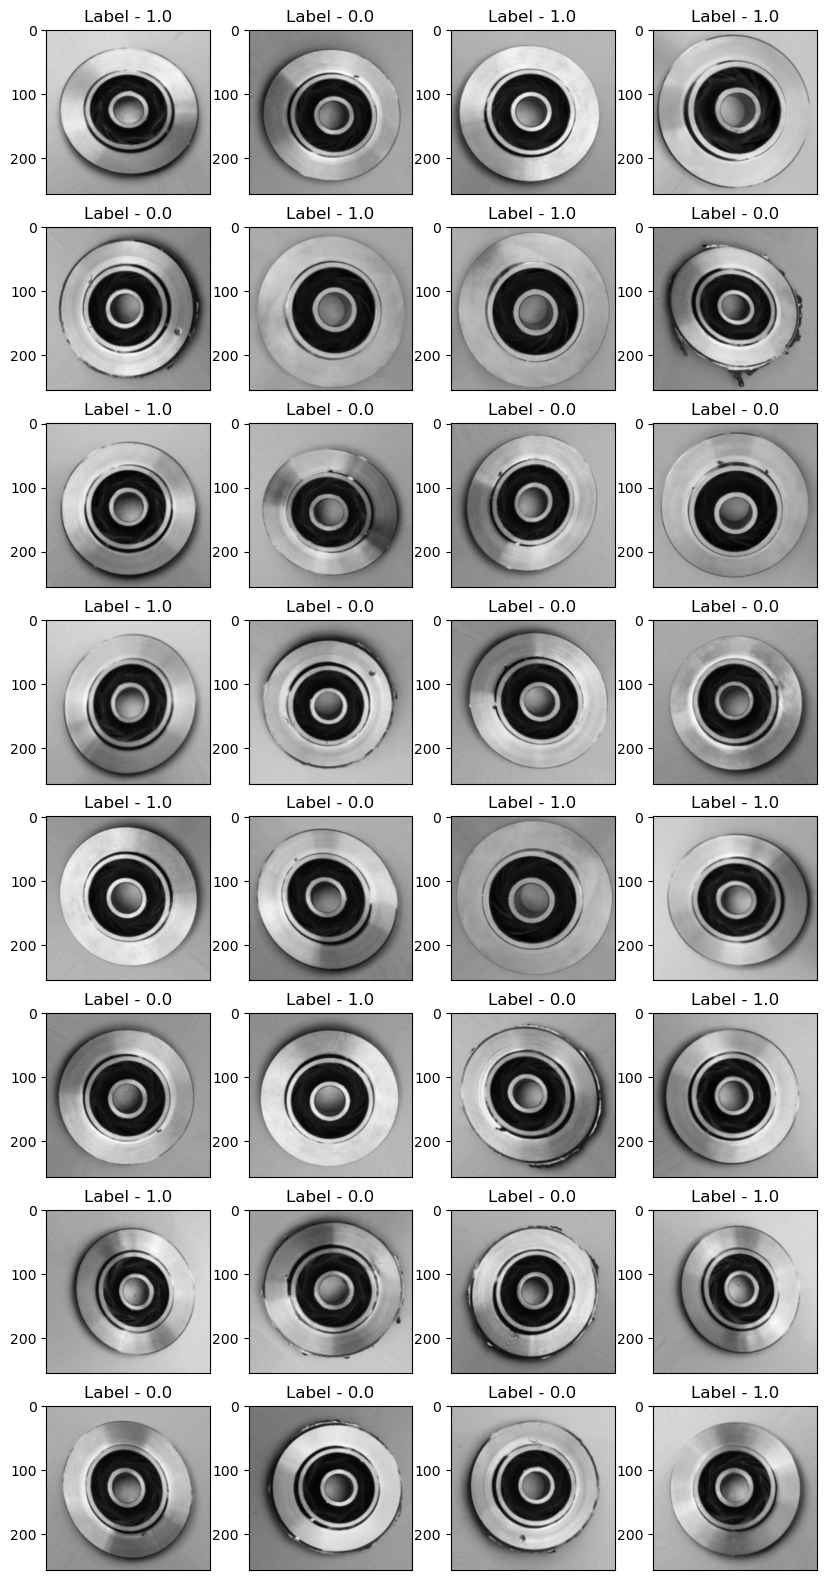

In [43]:
images, labels = next(iter(train_dataset))
fig, ax = plt.subplots(8, 4, figsize = (10, 20))
for i in range(8):
    for j in range(4):
        ax[i][j].imshow(images[4*i+j])
        ax[i][j].set_title(f"Label - {labels[4*i+j]}")
        ax[i][j].set_xticks([])

In [44]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])

model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 81920)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               20971776  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23230017 (88.62 MB)
Trainable params: 20972033 (80.00 MB)
Non-trainable params: 2257984 (8.61 MB)
________

In [45]:
model.fit(train_dataset,
         epochs = 10,
          validation_data = val_dataset
         )

Epoch 1/10
166/166 [==============================] - 62s 370ms/step - loss: 1.5515 - accuracy: 0.9178 - val_loss: 0.0319 - val_accuracy: 0.9910
Epoch 2/10
166/166 [==============================] - 60s 358ms/step - loss: 0.0228 - accuracy: 0.9943 - val_loss: 0.0270 - val_accuracy: 0.9955
Epoch 3/10
166/166 [==============================] - 60s 360ms/step - loss: 0.0138 - accuracy: 0.9964 - val_loss: 0.0216 - val_accuracy: 0.9947
Epoch 4/10
166/166 [==============================] - 57s 345ms/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 0.0235 - val_accuracy: 0.9955
Epoch 5/10
166/166 [==============================] - 58s 348ms/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.0341 - val_accuracy: 0.9917
Epoch 6/10
166/166 [==============================] - 60s 364ms/step - loss: 0.0164 - accuracy: 0.9953 - val_loss: 0.0215 - val_accuracy: 0.9940
Epoch 7/10
166/166 [==============================] - 65s 392ms/step - loss: 0.0095 - accuracy: 0.9962 - val_loss: 0.0336 - val_ac

In [46]:
xtest, ytest = next(iter(val_dataset))

In [47]:
ypred = model.predict(xtest)
ypred = np.squeeze(ypred)

1/1 [==============================] - 1s 1s/step


In [48]:
for i in range(0, len(ypred)):
    if ypred[i] > 0.5:
        ypred[i] = 1
    else:
        ypred[i] = 0

In [49]:
from sklearn.metrics import classification_report
rep = pd.DataFrame(classification_report(ytest, ypred, output_dict = True))
rep

,0.0,1.0,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,18.0,14.0,1.0,32.0,32.0


In [50]:
ypred

array([0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.],
      dtype=float32)

In [51]:
result = []
for i in range(len(ypred)):
    if ypred[i] == 0:
        result.append("DEFECTIVE")
    else:
        result.append("NON-DEFECTIVE")
result

['DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'NON-DEFECTIVE',
 'NON-DEFECTIVE',
 'NON-DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE']

In [52]:
true = []
for i in range(len(ytest)):
    if ytest[i] == 0:
        true.append("DEFECTIVE")
    else:
        true.append("NON-DEFECTIVE")

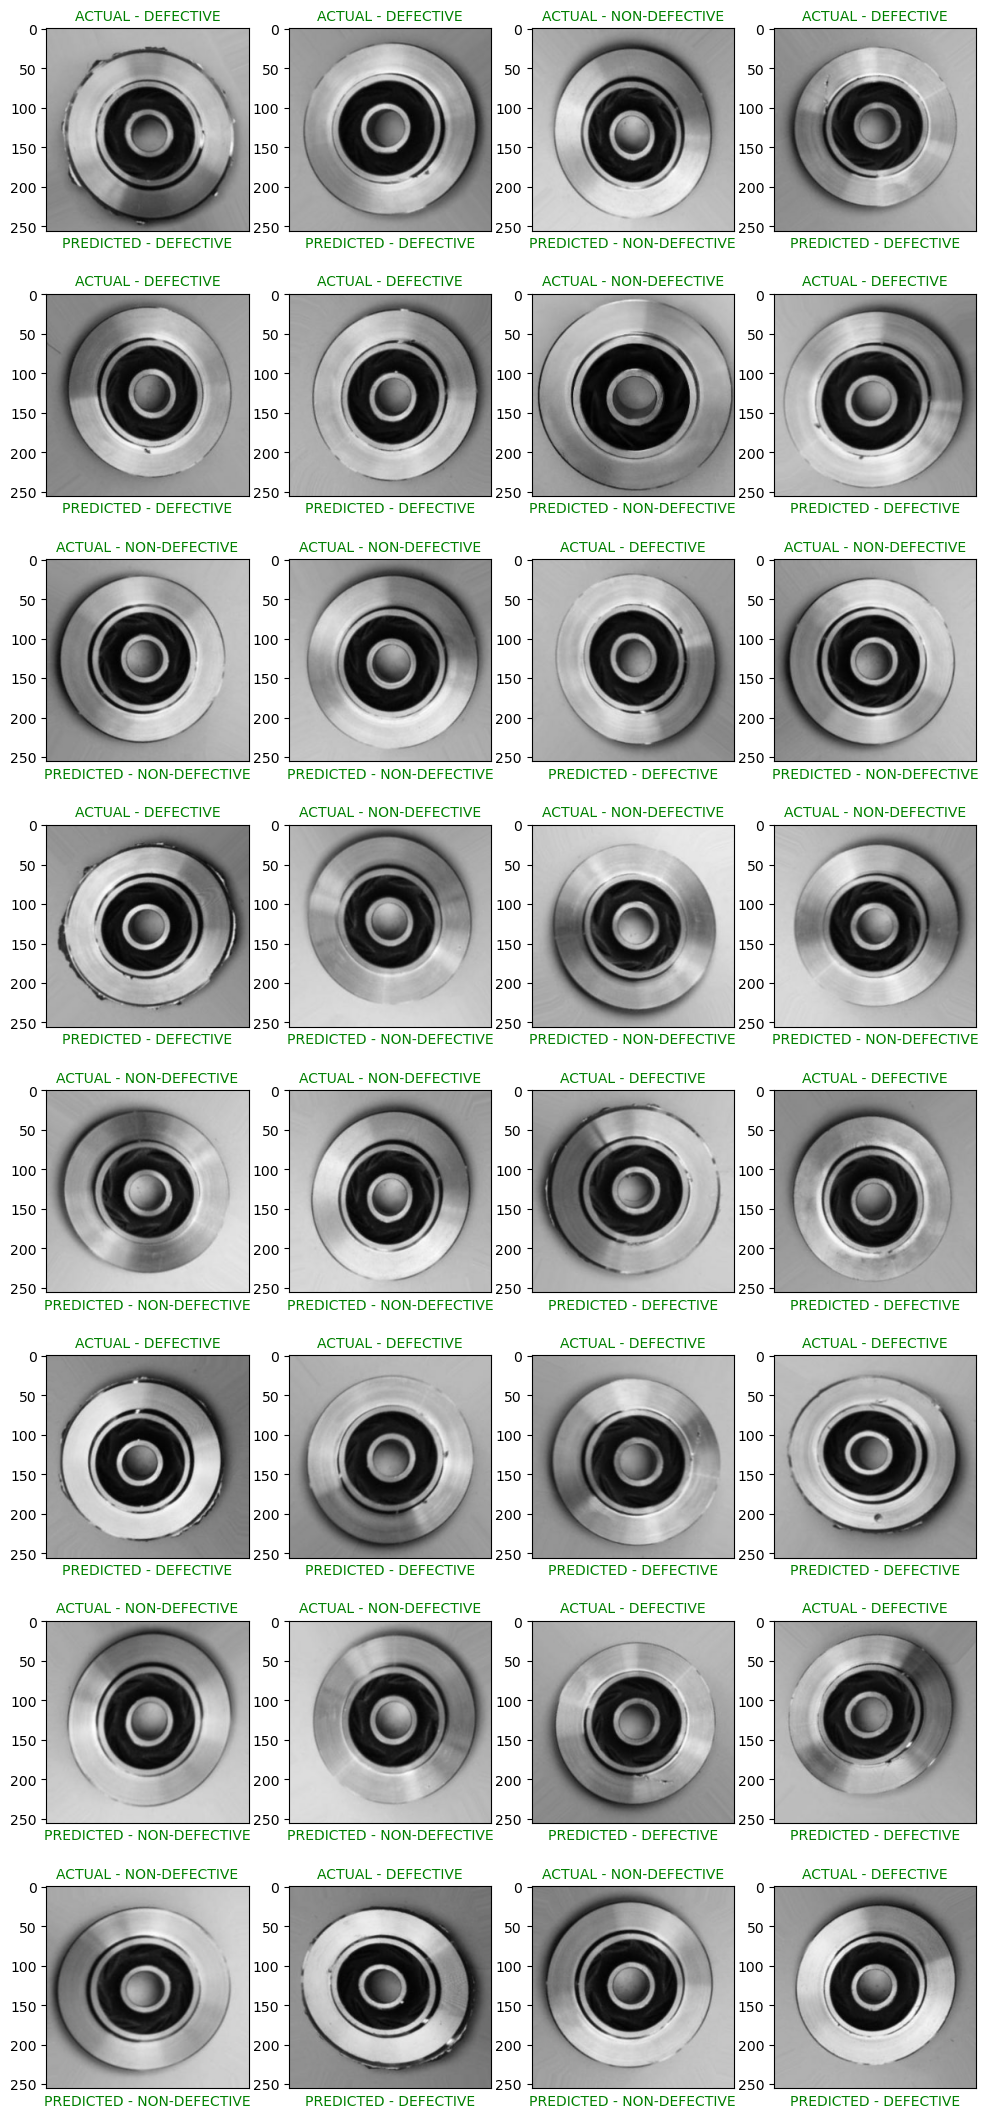

In [53]:
fig, ax = plt.subplots(8, 4, figsize = (12, 27))
for i in range(8):
    for j in range(4):
        ax[i][j].imshow(xtest[4*i+j])
        if ytest[4*i+j] == ypred[4*i+j]:
            ax[i][j].set_title(f"ACTUAL - {(result)[4*i+j]}", color = "green", size = 10)
            ax[i][j].set_xlabel(f"PREDICTED - {true[4*i+j]}", color = "green", size = 10)
        else:
            ax[i][j].set_title(f"ACTUAL - {(result)[4*i+j]}", color = "red", size = 10)
            ax[i][j].set_xlabel(f"PREDICTED - {true[4*i+j]}", color = "red", size = 10)
        ax[i][j].set_xticks([])